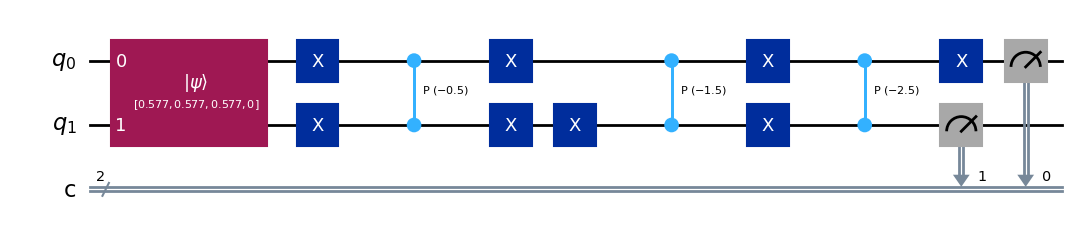

In [7]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import math

simulator = AerSimulator()


omega = 1.0     # Frecuencia del oscilador
t = 1.0         # Tiempo de evolución
phi0 = -omega * t / 2         # Fase para |00⟩
phi1 = -3 * omega * t / 2     # Fase para |01⟩
phi2 = -5 * omega * t / 2     # Fase para |10⟩

# Crear circuito con 2 qubits y 2 bits clásicos
qc = QuantumCircuit(2, 2)

# 1. Preparar superposición inicial (puede incluir |11>)

psi = [math.sqrt(1/3), math.sqrt(1/3), math.sqrt(1/3), 0] 
qc.initialize(psi, [0, 1])  # Inicializar el estado |ψ⟩

# A continuación se aplicar la fase utilizando cp, una compuerta simétrica
# que solo aplica una fase al estado |11>. Para controlar, se utilizan Nots.

# Apply phase e^{iϕ0} to |00⟩
qc.x(0)
qc.x(1)
qc.cp(phi0, 0, 1)  # (masked |00⟩)
qc.x(1)
qc.x(0)

# Apply phase e^{iϕ1} to |01⟩
qc.x(1)
qc.cp(phi1, 0, 1)  #  (masked |01⟩)
qc.x(1)

# Apply phase e^{iϕ2} to |10⟩
qc.x(0)
qc.cp(phi2, 0, 1)  # (masked |10⟩)
qc.x(0)



qc.measure([0, 1], [0, 1])  # Medir ambos qubits


# Dibujar el circuito
qc.draw('mpl', fold=False)


In [8]:
from qiskit.visualization import plot_histogram

# Simular 1000 ejecuciones
job = simulator.run(qc, shots=1000)
result = job.result()
counts = result.get_counts(qc)

print(counts)



{'00': 344, '10': 336, '01': 320}


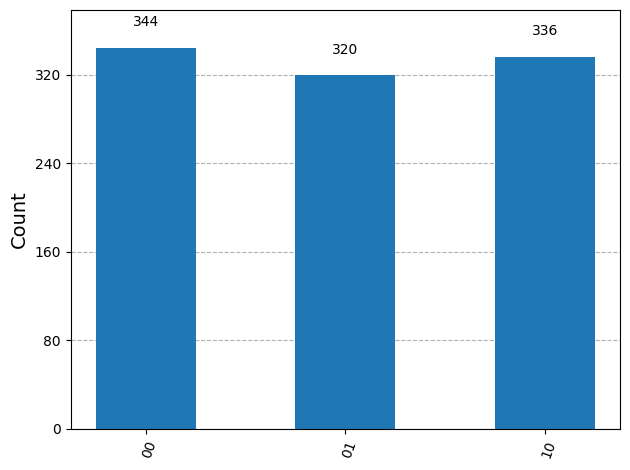

In [9]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

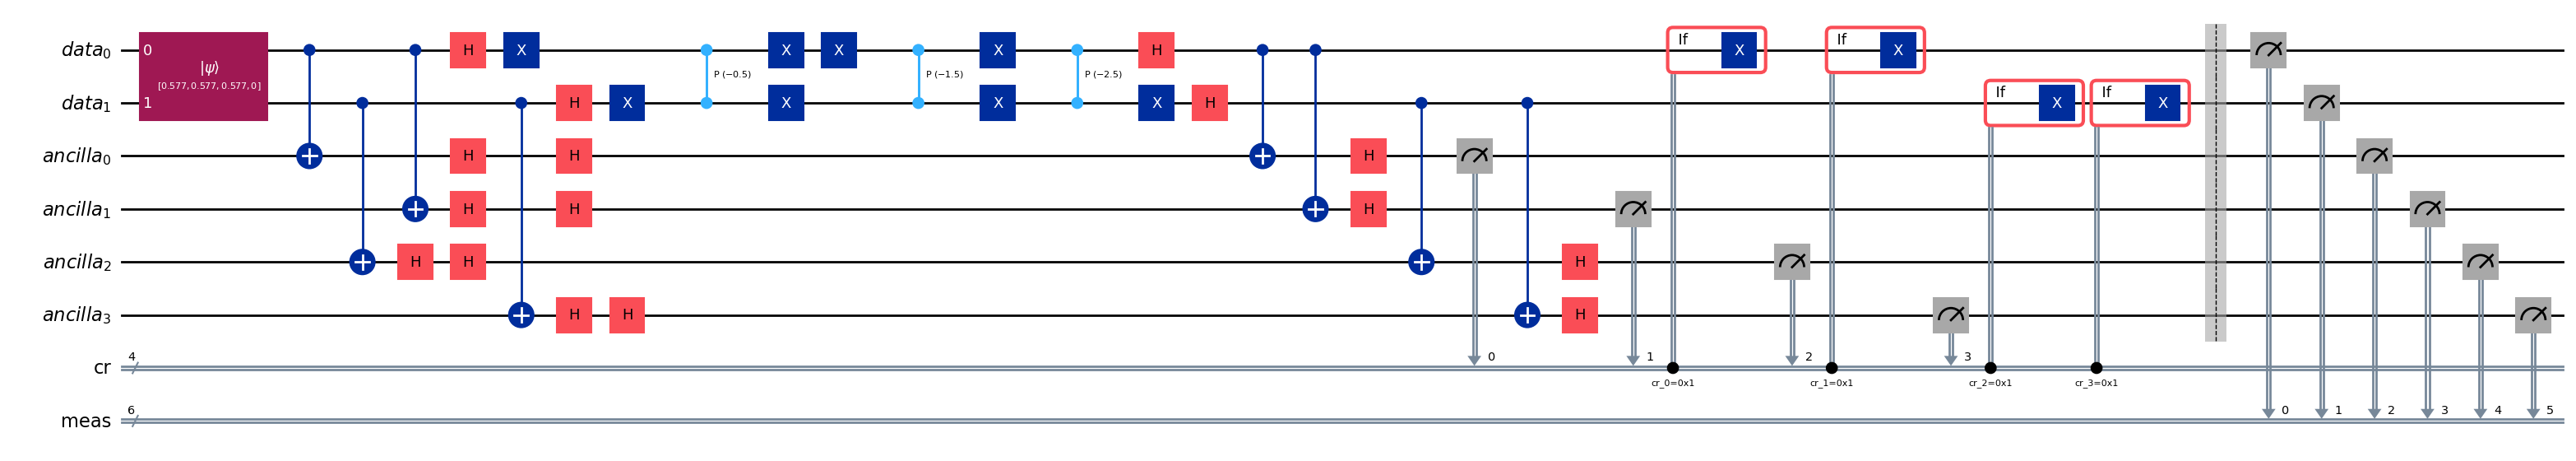

In [17]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import math
from qiskit.circuit.library import ZGate
# Define registers
data_q = QuantumRegister(2, 'data')  # Original data qubits
ancilla_q = QuantumRegister(4, 'ancilla')  # Ancillas for encoding/syndrome
cr = ClassicalRegister(4, 'cr')  # Classical register for measurement
qc = QuantumCircuit(data_q, ancilla_q, cr)

omega = 1.0     # Frecuencia del oscilador
t = 1.0         # Tiempo de evolución
phi0 = -omega * t / 2         # Fase para |00⟩
phi1 = -3 * omega * t / 2     # Fase para |01⟩
phi2 = -5 * omega * t / 2     # Fase para |10⟩

# ====================
psi = [1/math.sqrt(3), 1/math.sqrt(3), 1/math.sqrt(3), 0]  # [|00>, |01>, |10>, |11>]
qc.initialize(psi, data_q)

# Encode first data qubit across ancilla[0:2]
qc.cx(data_q[0], ancilla_q[0])
qc.cx(data_q[0], ancilla_q[1])
qc.h([data_q[0], ancilla_q[0], ancilla_q[1]])

# Encode second data qubit across ancilla[2:4]
qc.cx(data_q[1], ancilla_q[2])
qc.cx(data_q[1], ancilla_q[3])
qc.h([data_q[1], ancilla_q[2], ancilla_q[3]])

# ====================
# 2. APPLY PHASE OPERATIONS (LOGICAL VERSION)
# ====================
# Apply phase to |00> logical state
qc.x([data_q[0], data_q[1]])
qc.cp(phi0, data_q[0], data_q[1])
qc.x([data_q[1], data_q[0]])

# Apply phase to |01> logical state
qc.x(data_q[0])
qc.cp(phi1, data_q[0], data_q[1])
qc.x(data_q[0])

# Apply phase to |10> logical state
qc.x(data_q[1])
qc.cp(phi2, data_q[0], data_q[1])
qc.x(data_q[1])

# ====================
# 3. ERROR DETECTION & CORRECTION
# ====================
# Return to computational basis for syndrome measurement
qc.h([data_q[0], ancilla_q[0], ancilla_q[1], 
      data_q[1], ancilla_q[2], ancilla_q[3]])



# Apply CNOTs to ancillas for syndrome measurement
# Measure ancillas to detect errors in first logical qubit
qc.cx(data_q[0], ancilla_q[0])
qc.cx(data_q[0], ancilla_q[1])
qc.h([ancilla_q[0], ancilla_q[1]])
qc.measure([ancilla_q[0], ancilla_q[1]], [cr[0], cr[1]])

# Correction for first logical qubit
with qc.if_test((cr[0], 1)):  # If first stabilizer triggered
    qc.x(data_q[0])
with qc.if_test((cr[1], 1)):  # If second stabilizer triggered
    qc.x(data_q[0])

# Repeat for second logical qubit
qc.cx(data_q[1], ancilla_q[2])
qc.cx(data_q[1], ancilla_q[3])
qc.h([ancilla_q[2], ancilla_q[3]])
qc.measure([ancilla_q[2], ancilla_q[3]], [cr[2], cr[3]])

with qc.if_test((cr[2], 1)):
    qc.x(data_q[1])
with qc.if_test((cr[3], 1)):
    qc.x(data_q[1])

# ====================
# 4. Final Measurement
# ====================
qc.measure_all()
qc.draw('mpl', fold=False)

{'101110 1011': 33, '111111 1111': 6, '100011 1000': 28, '100100 1001': 18, '001110 0011': 9, '011110 0111': 26, '011011 0110': 4, '101101 1011': 6, '001100 0011': 12, '011111 0111': 21, '000010 0000': 12, '111011 1110': 22, '010010 0100': 25, '010101 0101': 34, '000110 0001': 18, '110110 1101': 22, '101011 1010': 4, '111101 1111': 35, '100001 1000': 7, '011010 0110': 5, '100000 1000': 16, '000111 0001': 21, '101000 1010': 21, '001111 0011': 10, '110001 1100': 41, '001011 0010': 26, '111110 1111': 9, '001000 0010': 11, '000001 0000': 29, '000000 0000': 14, '111100 1111': 18, '110000 1100': 13, '011001 0110': 26, '010011 0100': 28, '101100 1011': 10, '001101 0011': 27, '110011 1100': 10, '000100 0001': 8, '000011 0000': 6, '011101 0111': 3, '100101 1001': 37, '101001 1010': 27, '101111 1011': 16, '010110 0101': 17, '001010 0010': 26, '010100 0101': 10, '010000 0100': 12, '001001 0010': 2, '110100 1101': 7, '011100 0111': 13, '011000 0110': 18, '010001 0100': 6, '110111 1101': 18, '11100

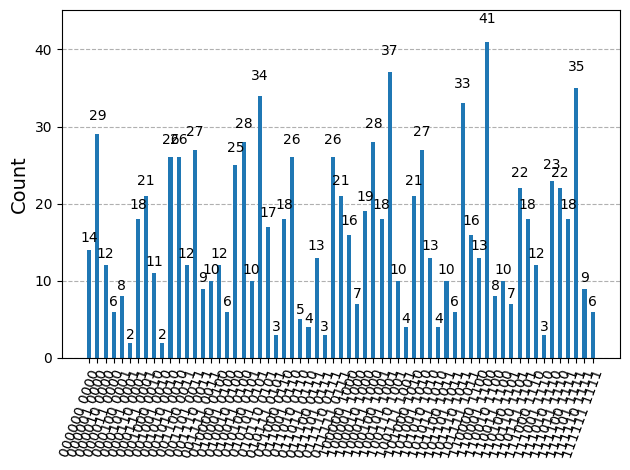

In [18]:
from qiskit.visualization import plot_histogram

# Simular 1000 ejecuciones
job = simulator.run(qc, shots=1000)
result = job.result()
counts = result.get_counts(qc)

print(counts)
plot_histogram(counts)


In [ ]:
from collections import defaultdict
# Analyze results
data_results = defaultdict(int)
syndrome_stats = defaultdict(int)

for bitstring, count in counts.items():
    # Split the measurement results
    syndrome = bitstring[:4]  # First 4 bits are ancilla measurements
    data = bitstring[4:6]      # Last 2 bits are data qubits
    
    # Count data results
    data_results[data] += count
    
    # Count syndrome patterns
    syndrome_stats[syndrome] += count

print("Final data qubit measurements:")
for state, count in sorted(data_results.items()):
    print(f"|{state}⟩: {count} times ({(count/1000)*100:.1f}%)")

print("\nSyndrome statistics:")
for syndrome, count in sorted(syndrome_stats.items()):
    print(f"{syndrome}: {count} times")

Final data qubit measurements:
|00 0000⟩: 14 times (1.4%)
|00 0001⟩: 8 times (0.8%)
|00 0010⟩: 11 times (1.1%)
|00 0011⟩: 12 times (1.2%)
|00 0100⟩: 12 times (1.2%)
|00 0101⟩: 10 times (1.0%)
|00 0110⟩: 18 times (1.8%)
|00 0111⟩: 13 times (1.3%)
|00 1000⟩: 16 times (1.6%)
|00 1001⟩: 18 times (1.8%)
|00 1010⟩: 21 times (2.1%)
|00 1011⟩: 10 times (1.0%)
|00 1100⟩: 13 times (1.3%)
|00 1101⟩: 7 times (0.7%)
|00 1110⟩: 12 times (1.2%)
|00 1111⟩: 18 times (1.8%)
|01 0000⟩: 29 times (2.9%)
|01 0001⟩: 2 times (0.2%)
|01 0010⟩: 2 times (0.2%)
|01 0011⟩: 27 times (2.7%)
|01 0100⟩: 6 times (0.6%)
|01 0101⟩: 34 times (3.4%)
|01 0110⟩: 26 times (2.6%)
|01 0111⟩: 3 times (0.3%)
|01 1000⟩: 7 times (0.7%)
|01 1001⟩: 37 times (3.7%)
|01 1010⟩: 27 times (2.7%)
|01 1011⟩: 6 times (0.6%)
|01 1100⟩: 41 times (4.1%)
|01 1110⟩: 3 times (0.3%)
|01 1111⟩: 35 times (3.5%)
|10 0000⟩: 12 times (1.2%)
|10 0001⟩: 18 times (1.8%)
|10 0010⟩: 26 times (2.6%)
|10 0011⟩: 9 times (0.9%)
|10 0100⟩: 25 times (2.5%)
|10 010